In [23]:
edges = [
    ('Başlangıç51', 'Ara64'), 
    ('Başlangıç52', 'Ara64'),
    ('Başlangıç56', 'Ara65'),
    ('Başlangıç57', 'Ara66'),
    ('Başlangıç67', 'Ara76'),
    ('Başlangıç68', 'Ara77'),
    ('Başlangıç70', 'Ara78'),
    ('Ara64', 'Ara65'), ('Ara64', 'Ara74'),
    ('Ara65', 'Ara66'), ('Ara65', 'Ara72'),
    ('Ara66', 'Ara73'), 
    ('Ara72', 'Ara73'), ('Ara72', 'Ara74'),
    ('Ara73', 'Ara75'),
    ('Ara74', 'Ara75'),
    ('Ara75', 'Ara76'), ('Ara75', 'Bit79'),
    ('Ara76', 'Ara77'), ('Ara76', 'Bit80'),
    ('Ara77', 'Ara78'),
    ('Ara78', 'Bit81'),
]

travel_time = {
    ('Başlangıç51', 'Ara64'):90, 
    ('Başlangıç52', 'Ara64'): 36,
    ('Başlangıç56', 'Ara65'): 27,
    ('Başlangıç57', 'Ara66'): 34.20,
    ('Başlangıç67', 'Ara76'): 50.4,
    ('Başlangıç68', 'Ara77'): 68.4,
    ('Başlangıç70', 'Ara78'): 72.00,
    ('Ara64', 'Ara65'): 86.4, ('Ara64', 'Ara74'): 90,
    ('Ara65', 'Ara66'): 79.2, ('Ara65', 'Ara72'): 14.4,
    ('Ara66', 'Ara73'): 23.4, 
    ('Ara72', 'Ara73'): 79.2, ('Ara72', 'Ara74'): 14.4,
    ('Ara73', 'Ara75'): 23.4,
    ('Ara74', 'Ara75'): 79.2,
    ('Ara75', 'Ara76'): 52.2, ('Ara75', 'Bit79'): 39.6,
    ('Ara76', 'Ara77'): 73.8, ('Ara76', 'Bit80'): 55.8,
    ('Ara77', 'Ara78'): 32.4,
    ('Ara78', 'Bit81'): 79.2,
}

capacity = {
    ('Başlangıç51', 'Ara64'):2200, 
    ('Başlangıç52', 'Ara64'): 4400,
    ('Başlangıç56', 'Ara65'): 6600,
    ('Başlangıç57', 'Ara66'): 4400,
    ('Başlangıç67', 'Ara76'): 6600,
    ('Başlangıç68', 'Ara77'): 2200,
    ('Başlangıç70', 'Ara78'): 6600,
    ('Ara64', 'Ara65'): 4400, ('Ara64', 'Ara74'): 4400,
    ('Ara65', 'Ara66'): 13200, ('Ara65', 'Ara72'): 6600,
    ('Ara66', 'Ara73'): 8800, 
    ('Ara72', 'Ara73'): 2200, ('Ara72', 'Ara74'): 4400,
    ('Ara73', 'Ara75'): 11000,
    ('Ara74', 'Ara75'): 6600,
    ('Ara75', 'Ara76'): 6600, ('Ara75', 'Bit79'): 11000,
    ('Ara76', 'Ara77'): 2200, ('Ara76', 'Bit80'): 11000,
    ('Ara77', 'Ara78'): 4400,
    ('Ara78', 'Bit81'): 11000,
}

passengers = {
    "Başlangıç51": 2000,
    "Başlangıç52": 1000,
    "Başlangıç56": 2200,
    "Başlangıç57": 2000,
    "Başlangıç67": 2800,
    "Başlangıç68": 3000,
    "Başlangıç70": 3000
}

In [1]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice

def k_shortest_paths(G, source, target, k):
    """
    Finds the k shortest paths between two nodes.
    """
    return list(islice(nx.shortest_simple_paths(G, source, target), k))

def create_graph(edges, capacity):
    """
    Creates a directed graph from the given edges with specified capacities.
    """
    G = nx.DiGraph()
    for (i, j) in edges:
        G.add_edge(i, j, capacity=capacity[(i, j)])
    return G

def create_evacuation_model(edges, passengers, capacity, base_travel_time, K=50):
    """
    Creates an evacuation model using Pyomo for the given graph and parameters.
    """
    G = create_graph(edges, capacity)
    
    model = pyo.ConcreteModel()
    
    all_nodes = set([i for (i, j) in edges] + [j for (i, j) in edges])
    start_nodes = sorted(set(n for n in all_nodes if n.startswith('Başlangıç')))  # Change prefix if necessary
    end_nodes = sorted(set(n for n in all_nodes if n.startswith('Bit')))            # Change prefix if necessary
    
    model.edges = pyo.Set(initialize=edges)
    model.start_nodes = pyo.Set(initialize=start_nodes)
    model.end_nodes = pyo.Set(initialize=end_nodes)
    
    paths = {}
    for s in start_nodes:
        for t in end_nodes:
            try:
                paths[(s, t)] = k_shortest_paths(G, s, t, K)
            except:
                continue
    
    model.paths = pyo.Set(initialize=[(s, t, k) for (s, t) in paths.keys() 
                                      for k in range(len(paths[(s, t)]))])
    
    model.edge_flow = pyo.Var(model.edges, domain=pyo.NonNegativeIntegers)
    model.path_flow = pyo.Var(model.paths, domain=pyo.NonNegativeIntegers)
    model.travel_time = pyo.Var(model.edges, domain=pyo.NonNegativeReals)
    
    model.Z = pyo.Var(domain=pyo.NonNegativeReals)
    
    model.objective = pyo.Objective(expr=model.Z, sense=pyo.minimize)
    
    def demand_rule(model, s):
        return sum(model.path_flow[s, t, k] 
                   for t in model.end_nodes 
                   for k in range(len(paths.get((s, t), [])))
                   if (s, t, k) in model.paths) == passengers[s]
    model.demand = pyo.Constraint(model.start_nodes, rule=demand_rule)
    
    def capacity_rule(model, i, j):
        return model.edge_flow[i, j] <= capacity[(i, j)]
    model.capacity = pyo.Constraint(model.edges, rule=capacity_rule)
    
    def flow_conservation(model, i, j):
        path_sum = sum(model.path_flow[s, t, k] 
                       for (s, t, k) in model.paths 
                       if (i, j) in zip(paths[(s, t)][k][:-1], paths[(s, t)][k][1:]))
        return model.edge_flow[i, j] == path_sum
    model.flow_conservation = pyo.Constraint(model.edges, rule=flow_conservation)
    
    def travel_time_rule(model, i, j):
        return model.travel_time[i, j] == base_travel_time[(i, j)] * \
               (1 + 2 * (model.edge_flow[i, j] / capacity[(i, j)])**2)
    model.travel_time_constraint = pyo.Constraint(model.edges, rule=travel_time_rule)
    
    def max_flow_constraint(model, i, j):
        return model.Z / model.travel_time[i, j] >= model.edge_flow[i, j]
    model.max_flow_constraint = pyo.Constraint(model.edges, rule=max_flow_constraint)
    
    return model, paths, G

def solve_model(model, base_time_dict, cap_dict):
    """
    Solves the given model using IPOPT and updates variable values accordingly.
    """
    solver = pyo.SolverFactory('ipopt')
    solver.options['max_cpu_time'] = 600  
    solver.options['tol'] = 1e-6
    solver.options['print_level'] = 3  # For more detailed output

    results = solver.solve(model, tee=True)

    for edge in model.edges:
        current_flow = pyo.value(model.edge_flow[edge])
        model.edge_flow[edge].set_value(round(current_flow))

    for path in model.paths:
        current_flow = pyo.value(model.path_flow[path])
        model.path_flow[path].set_value(round(current_flow))

    # Update travel times based on the new flows
    for i, j in model.edges:
        current_flow = pyo.value(model.edge_flow[i, j])
        base_time = base_time_dict[(i, j)]
        cap = cap_dict[(i, j)]
        new_time = base_time * (1 + 2 * (current_flow / cap)**2)
        model.travel_time[i, j].set_value(new_time)

    return results


In [3]:
import random
import numpy as np

def print_results(model, edges, capacity, G, paths):
    """
    Display and visualize the results.
    """
    print("\n==================== RESULTS ====================")
    print(f"Objective Value: {pyo.value(model.objective):.2f}")
    
    # Print Edge Flow Table
    print("\nEDGE FLOWS AND TRAVEL TIMES:")
    print("-" * 60)
    print(f"{'Edge':<20} {'Flow':<10} {'Travel Time':<15} {'Capacity Usage':<15}")
    print("-" * 60)
    
    flow_values = {}
    total_flow = 0
    total_travel_time = 0
    total_capacity_usage = 0
    
    for (i, j) in edges:
        flow = int(round(pyo.value(model.edge_flow[i, j])))
        flow_values[(i, j)] = flow
        total_flow += flow
        time = pyo.value(model.travel_time[i, j])
        total_travel_time += time
        capacity_usage = (flow / capacity[(i, j)]) * 100
        total_capacity_usage += capacity_usage
        
        print(f"{i} -> {j:<15} {flow:<10} {time:<15.2f} {capacity_usage:<15.1f}")
    
    print("-" * 60)
    
    print("\nPATH FLOWS:")
    print("-" * 80)
    print(f"{'Source':<15} {'Target':<15} {'Path #':<5} {'Flow':>10} {'Time':>10}")
    print("-" * 80)
    
    path_times = []
    path_flow_weighted_times = []
    total_path_flows = []
    
    for s in model.baslangic_nodes:
        for t in model.bitis_nodes:
            for k in range(len(paths.get((s, t), []))):
                if (s, t, k) in model.path_flow:
                    flow = int(round(pyo.value(model.path_flow[s, t, k])))
                    if flow > 0:
                        total_path_flows.append(flow)
                        path = paths[(s, t)][k]
                        total_time = 0
                        individual_times = []
                        
                        for i in range(len(path) - 1):
                            edge = (path[i], path[i + 1])
                            edge_time = pyo.value(model.travel_time[edge])
                            total_time += edge_time
                            individual_times.append(edge_time)
                        
                        # Append path time and weighted flow*time for later calculations
                        path_times.append(total_time)
                        path_flow_weighted_times.append(flow * total_time)
                        
                        print(f"{s:<15} {t:<15} {k + 1:>5} {flow:>10} {total_time:>10.2f}")
                        print(f"    Path: {' -> '.join(path)}")
    
    if total_path_flows:
        max_path_time = max(path_times) if path_times else 0
        min_path_time = min(path_times) if path_times else 0
        total_path_flow = sum(total_path_flows)
        weighted_avg_time = (
            sum(path_flow_weighted_times) / total_path_flow if total_path_flow > 0 else 0
        )
        
        print("\nPATH TIME SUMMARY:")
        print(f"Minimum Path Time: {min_path_time:.2f}")
        print(f"Maximum Path Time: {max_path_time:.2f}")
        print(f"Flow-Weighted Average Path Time: {weighted_avg_time:.2f}")

def print_passenger_distribution(passengers):
    print("\n========= BAŞLANGIÇ NOKTALARI YOLCU DAĞILIMI =========")
    print("-" * 50)
    print(f"{'Başlangıç Noktası':<20} {'Yolcu Sayısı':>15}")
    print("-" * 50) 
    
    toplam_yolcu = 0
    for node, count in passengers.items():
        if node.startswith('Başlangıç') and count > 0:
            print(f"{node:<20} {count:>15,}")
            toplam_yolcu += count
    
    print("-" * 50)
    print(f"{'TOPLAM':<20} {toplam_yolcu:>15,}")
    print("-" * 50)
    
    return toplam_yolcu

def analyze_model(model, edges, capacity, stage_label):
    print(f"\n===== {stage_label} ANAL\u0130Z\u0130 =====")
    
    # Toplam ak\u0131\u015f miktar\u0131
    total_flow = sum(pyo.value(model.edge_flow[e]) for e in edges)
    
    # Ortalama seyahat süresi
    avg_travel_time = sum(pyo.value(model.travel_time[e]) for e in edges) / len(edges)
    
    # Kapasite kullanım oranları
    max_utilization = 0
    most_congested_edge = None
    utilizations = []
    
    # Toplam seyahat süreleri hesaplama
    total_travel_time = 0
    edge_travel_times = {}
    
    for e in edges:
        flow = pyo.value(model.edge_flow[e])
        travel_time = pyo.value(model.travel_time[e])
        cap = capacity[e]
        util = flow / cap if cap > 0 else 0
        utilizations.append(util)

        if util > max_utilization:
            max_utilization = util
            most_congested_edge = e
        
        # Her bir kenarın toplam seyahat süresi
        edge_total_time = flow * travel_time
        edge_travel_times[e] = edge_total_time
        total_travel_time += edge_total_time

    # Sonuçları ekrana yazdırma
    print(f"Toplam Akış Miktarı: {total_flow}")
    print(f"Ortalama Seyahat Süresi: {avg_travel_time:.2f}")
    print(f"En Yüksek Kapasite Kullanımı: {max_utilization*100:.1f}% (Kenar: {most_congested_edge})")
    print(f"Tüm Kenarlar İçin Toplam Seyahat Süresi: {total_travel_time:.2f}")

    print("\nHer Kenarın Toplam Seyahat Süreleri:")
    for e, time in edge_travel_times.items():
        print(f"  Kenar {e}: {time:.2f}")
    
    # Kapasite kullanım oranlarının histogramını oluşturma
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.hist(utilizations, bins=20, color='blue', alpha=0.7)
    plt.title(f"{stage_label} - Kapasite Kullanım Dağılımı")
    plt.xlabel("Kapasite Kullanım Oranı")
    plt.ylabel("Kenar Sayısı")
    plt.grid(True)
    plt.show()

In [4]:
def visualize_single_stage(model, edges, capacity, G, stage_label="Stage Visualization"):
    """
    Tek bir aşamanın ağını görselleştirir.
    Kenar renkleri kapasite kullanımına göre belirlenir.
    Düğümler başlangıç, bitiş ve ara düğümler olarak hizalanır.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Genel konumlandırma için spring layout
    pos = nx.spring_layout(G, seed=42)
    
    # Düğümleri kategorilere ayır
    start_nodes = sorted([n for n in G.nodes() if n.startswith('Başlangıç')])
    finish_nodes = sorted([n for n in G.nodes() if n.startswith('Bit')])
    other_nodes = sorted(set(G.nodes()) - set(start_nodes) - set(finish_nodes))
    
    # Başlangıç düğümlerini hizalama (sol taraf)
    for i, node in enumerate(start_nodes):
        y = 1 - 2*i/(len(start_nodes)-1) if len(start_nodes)>1 else 0
        pos[node] = (-1, y)
    
    # Bitiş düğümlerini hizalama (sağ taraf)
    for i, node in enumerate(finish_nodes):
        y = 1 - 2*i/(len(finish_nodes)-1) if len(finish_nodes)>1 else 0
        pos[node] = (1, y)
    
    # Ara düğümleri hizalama (orta), bağlantılarına bağlı olarak sola/sağa kaydırma
    for i, node in enumerate(other_nodes):
        y = 1 - 2*i/(len(other_nodes)-1) if len(other_nodes)>1 else 0
        
        # Ara düğümün bağlantılarına göre x konumu hesaplama
        x_positions = []
        # Gelen kenarlar için (bu düğüm hedefse) sola kaydır
        for predecessor in G.predecessors(node):
            if predecessor in other_nodes:
                x_positions.append(-0.5)
        # Giden kenarlar için (bu düğüm kaynaksa) sağa kaydır
        for successor in G.successors(node):
            if successor in other_nodes:
                x_positions.append(0.5)
        
        x = sum(x_positions)/len(x_positions) if x_positions else 0
        pos[node] = (x, y)
    
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=300, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
    
    # Kenar renklerini akışa göre belirle
    edge_colors = []
    for (u, v) in G.edges():
        try:
            flow = pyo.value(model.edge_flow[u, v])
        except KeyError:
            flow = 0
        ratio = flow / capacity[(u, v)] if capacity[(u, v)] > 0 else 0
        
        if ratio <= 0.25:
            edge_colors.append('green')
        elif ratio <= 0.5:
            edge_colors.append('yellow')
        elif ratio <= 0.75:
            edge_colors.append('orange')
        else:
            edge_colors.append('red')
    
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, arrowsize=10)
    
    ax.set_title(stage_label)
    ax.axis('off')
    plt.show()


In [5]:
def run_single_phase_optimization():
    # TEK FAZ - AŞAMA 1'e odaklanma
    print("SINGLE PHASE OPTIMIZATION")
    print("-------------------------")
    
    toplam_yolcu = print_passenger_distribution(passengers)
    
    model, paths, G = create_evacuation_model(edges, passengers, capacity, travel_time)
    
    results = solve_model(model, travel_time, capacity)
    if results:
        print_results(model, edges, capacity, G, paths)
        analyze_model(model, edges, capacity, "Single Phase")
    
    if results:
        visualize_single_stage(model, edges, capacity, G, stage_label="Stage 1 Visualization")

# Modeli çalıştır
# if __name__ == "__main__":
#     run_single_phase_optimization()


In [39]:
edges = [
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"),
    ("Başlangıç1", "Bit2"),
    ("Başlangıç1", "Bit3"),
]

capacity = {
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"):1000,
    ("Başlangıç1", "Bit2"):1000,
    ("Başlangıç1", "Bit3"):1000
}

travel_time = {
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"):50,
    ("Başlangıç1", "Bit2"):50,
    ("Başlangıç1", "Bit3"):50,
}

passengers = {
    "Başlangıç1": 1500,
}

SINGLE PHASE OPTIMIZATION
-------------------------

========= BAŞLANGIÇ NOKTALARI YOLCU DAĞILIMI =========
--------------------------------------------------
Başlangıç Noktası       Yolcu Sayısı
--------------------------------------------------
Başlangıç1                     1,500
--------------------------------------------------
TOPLAM                         1,500
--------------------------------------------------
Ipopt 3.14.17: max_iter=10000
tol=1e-06
print_level=5

==> Warning: Treating 0 binary and 6 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 

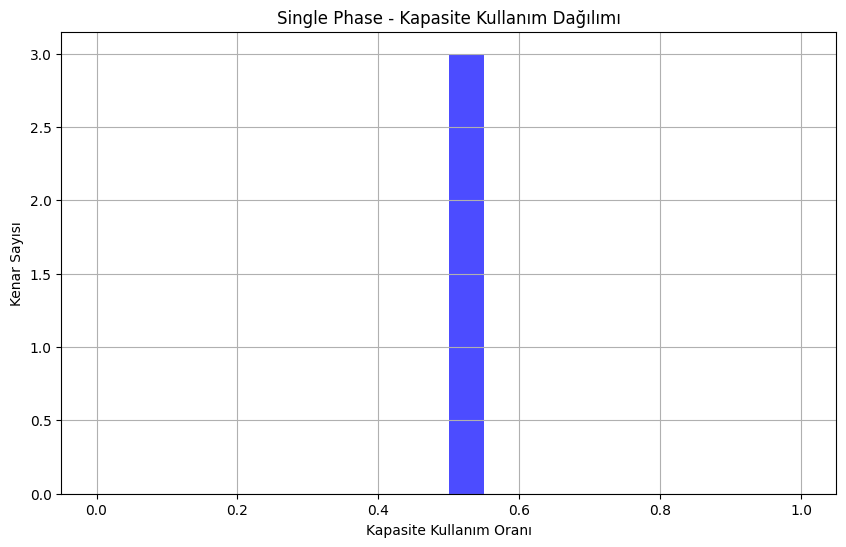

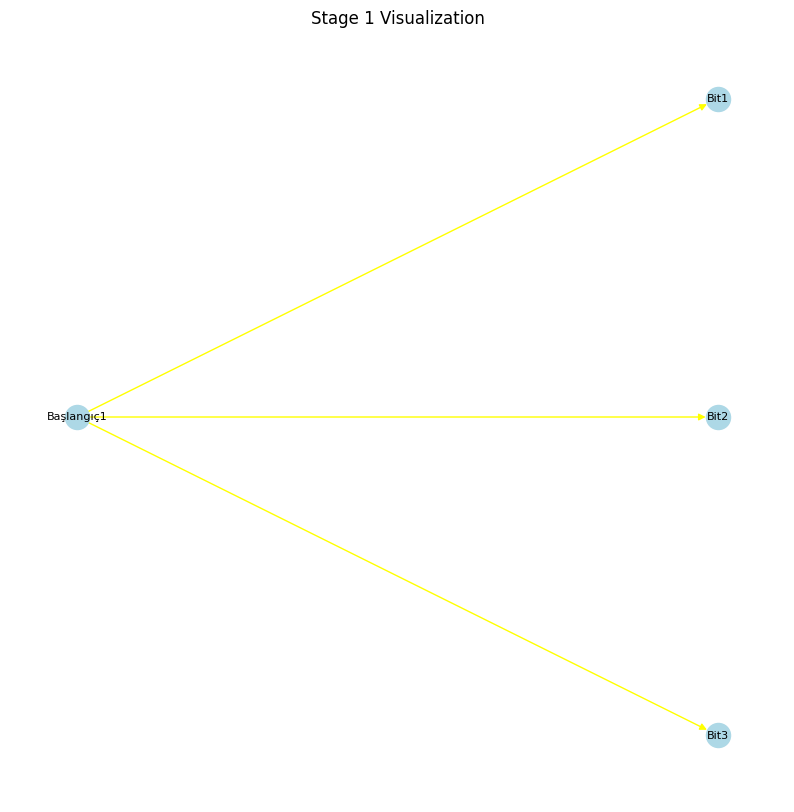

In [40]:
run_single_phase_optimization()

In [41]:
edges = [
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"),
    ("Başlangıç1", "Bit2"),
    ("Başlangıç1", "Bit3"),
]

capacity = {
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"):1000,
    ("Başlangıç1", "Bit2"):1000,
    ("Başlangıç1", "Bit3"):1000
}

travel_time = {
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"):40,
    ("Başlangıç1", "Bit2"):50,
    ("Başlangıç1", "Bit3"):60,
}

passengers = {
    "Başlangıç1": 1500,
}

SINGLE PHASE OPTIMIZATION
-------------------------

========= BAŞLANGIÇ NOKTALARI YOLCU DAĞILIMI =========
--------------------------------------------------
Başlangıç Noktası       Yolcu Sayısı
--------------------------------------------------
Başlangıç1                     1,500
--------------------------------------------------
TOPLAM                         1,500
--------------------------------------------------
Ipopt 3.14.17: max_iter=10000
tol=1e-06
print_level=5

==> Warning: Treating 0 binary and 6 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 

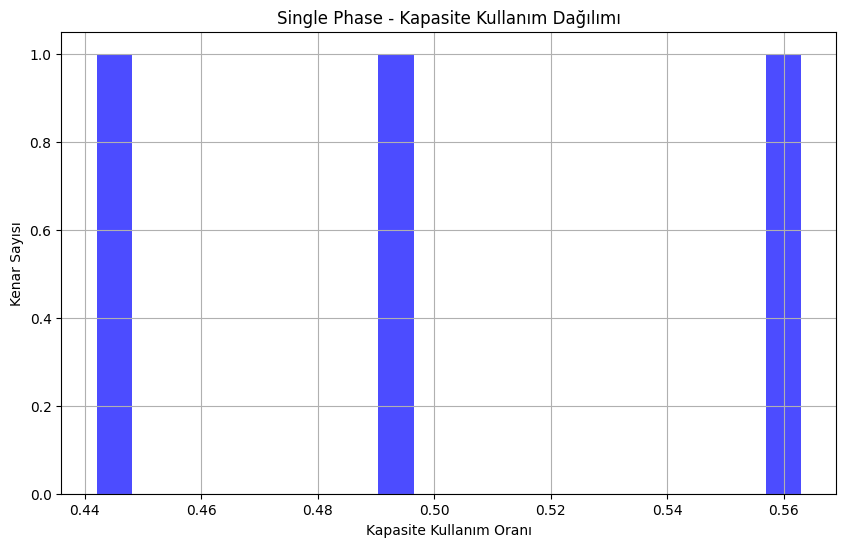

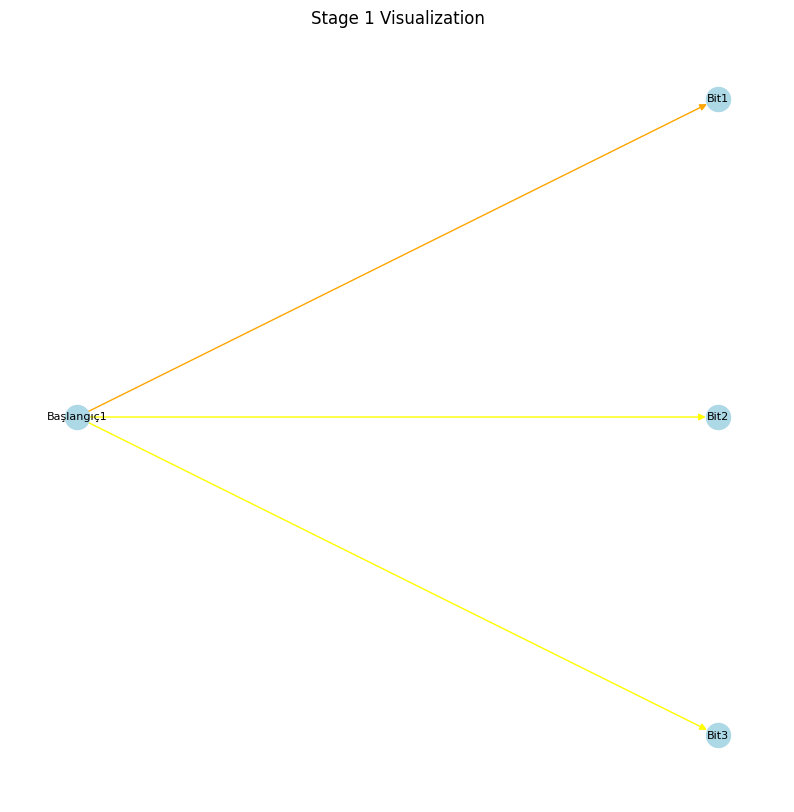

In [42]:
run_single_phase_optimization()

In [52]:
edges = [
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"),
    ("Başlangıç1", "Bit2"),
    ("Başlangıç1", "Bit3"),
]

capacity = {
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"):1000,
    ("Başlangıç1", "Bit2"):1000,
    ("Başlangıç1", "Bit3"):1000
}

travel_time = {
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"):40,
    ("Başlangıç1", "Bit2"):50,
    ("Başlangıç1", "Bit3"):60,
}

passengers = {
    "Başlangıç1": 3001,
}

SINGLE PHASE OPTIMIZATION
-------------------------

========= BAŞLANGIÇ NOKTALARI YOLCU DAĞILIMI =========
--------------------------------------------------
Başlangıç Noktası       Yolcu Sayısı
--------------------------------------------------
Başlangıç1                     3,001
--------------------------------------------------
TOPLAM                         3,001
--------------------------------------------------
Ipopt 3.14.17: max_iter=10000
tol=1e-06
print_level=5

==> Warning: Treating 0 binary and 6 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 

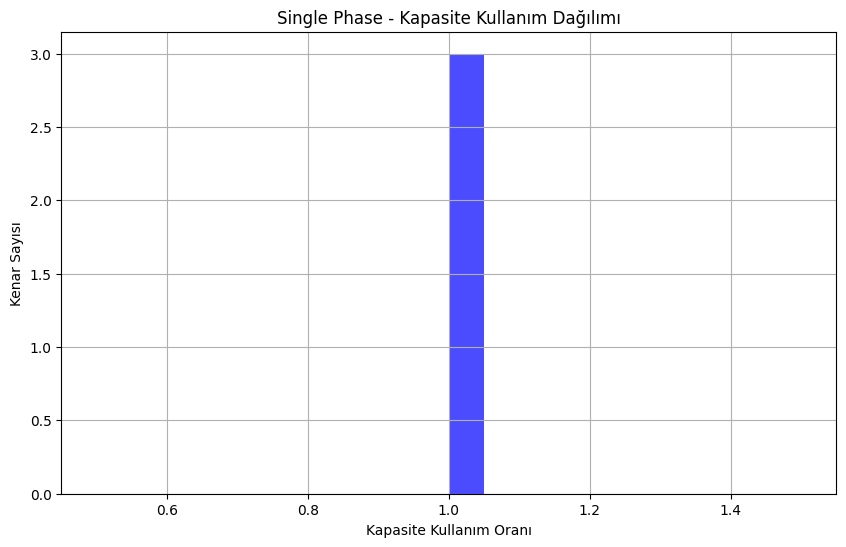

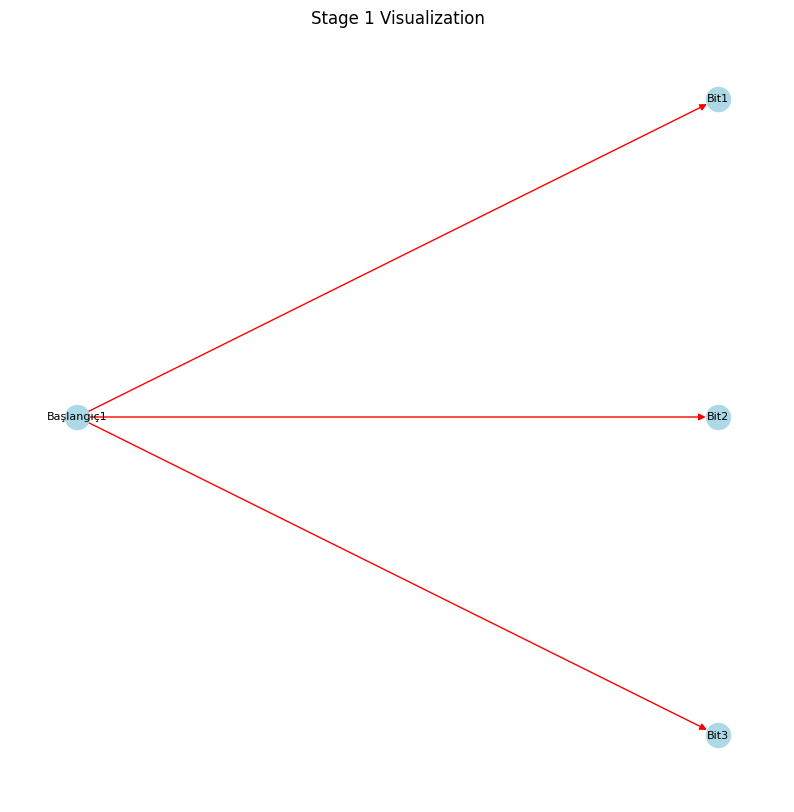

In [53]:
run_single_phase_optimization()


In [54]:
edges = [
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"),
    ("Başlangıç1", "Bit2"),
    ("Başlangıç1", "Bit3"),
]

capacity = {
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"):1000,
    ("Başlangıç1", "Bit2"):10000,
    ("Başlangıç1", "Bit3"):1000
}

travel_time = {
    # From Başlangıç nodes
    ("Başlangıç1", "Bit1"):50,
    ("Başlangıç1", "Bit2"):50,
    ("Başlangıç1", "Bit3"):50,
}

passengers = {
    "Başlangıç1": 3000,
}

SINGLE PHASE OPTIMIZATION
-------------------------

========= BAŞLANGIÇ NOKTALARI YOLCU DAĞILIMI =========
--------------------------------------------------
Başlangıç Noktası       Yolcu Sayısı
--------------------------------------------------
Başlangıç1                     3,000
--------------------------------------------------
TOPLAM                         3,000
--------------------------------------------------
Ipopt 3.14.17: max_iter=10000
tol=1e-06
print_level=5

==> Warning: Treating 0 binary and 6 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 

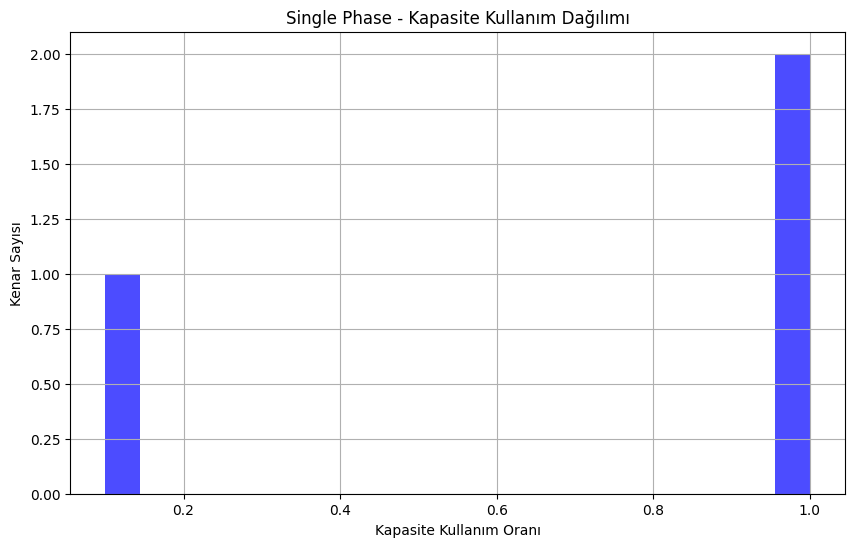

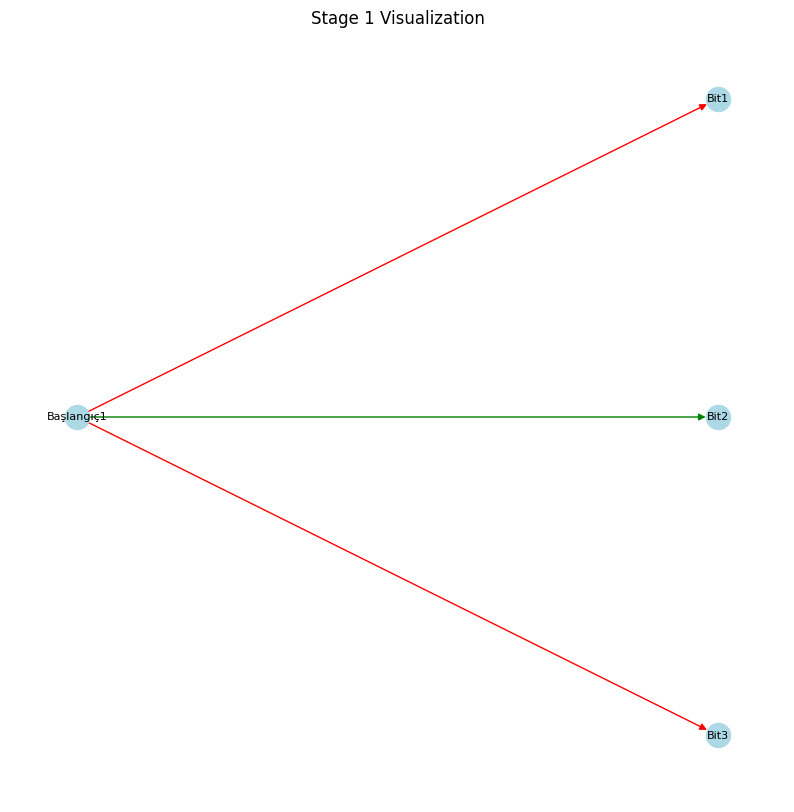

In [55]:
run_single_phase_optimization()


In [6]:
# Yeni ağ yapısı
edges = [
    ('Başlangıç51', 'Başlangıç52'), ('Başlangıç51', 'Ara64'), 
    ('Başlangıç52', 'Başlangıç51'), ('Başlangıç52', 'Başlangıç56'), ('Başlangıç52', 'Ara64'),
    ('Başlangıç56', 'Başlangıç57'), ('Başlangıç57', 'Başlangıç56'), ('Başlangıç56', 'Ara65'),
    ('Başlangıç57', 'Başlangıç67'), ('Başlangıç57', 'Başlangıç56'), ('Başlangıç57', 'Ara66'),
    ('Başlangıç67', 'Başlangıç57'), ('Başlangıç67', 'Başlangıç68'), ('Başlangıç67', 'Ara76'),
    ('Başlangıç68', 'Başlangıç67'), ('Başlangıç68', 'Başlangıç70'), ('Başlangıç68', 'Ara77'),
    ('Başlangıç70', 'Başlangıç68'), ('Başlangıç70', 'Ara78'),
    ('Ara64', 'Ara65'), ('Ara64', 'Ara74'),
    ('Ara65', 'Ara66'), ('Ara65', 'Ara72'),
    ('Ara66', 'Ara73'), 
    ('Ara72', 'Ara73'), ('Ara72', 'Ara74'),
    ('Ara73', 'Ara75'),
    ('Ara74', 'Ara75'),
    ('Ara75', 'Ara76'), ('Ara75', 'Bit79'),
    ('Ara76', 'Ara77'), ('Ara76', 'Bit80'),
    ('Ara77', 'Ara78'),
    ('Ara78', 'Bit81'),
]

# Yeni seyahat süreleri
travel_time = {
    ('Başlangıç51', 'Başlangıç52'):0, ('Başlangıç51', 'Ara64'):90, 
    ('Başlangıç52', 'Başlangıç51'):0, ('Başlangıç52', 'Başlangıç56'):0, ('Başlangıç52', 'Ara64'): 36,
    ('Başlangıç56', 'Başlangıç57'):0, ('Başlangıç57', 'Başlangıç56'):0, ('Başlangıç56', 'Ara65'): 27,
    ('Başlangıç57', 'Başlangıç67'):0, ('Başlangıç57', 'Başlangıç56'):0, ('Başlangıç57', 'Ara66'): 34.20,
    ('Başlangıç67', 'Başlangıç57'):0, ('Başlangıç67', 'Başlangıç68'):0, ('Başlangıç67', 'Ara76'): 50.4,
    ('Başlangıç68', 'Başlangıç67'):0, ('Başlangıç68', 'Başlangıç70'):0, ('Başlangıç68', 'Ara77'): 68.4,
    ('Başlangıç70', 'Başlangıç68'):0, ('Başlangıç70', 'Ara78'): 72.00,
    ('Ara64', 'Ara65'): 86.4, ('Ara64', 'Ara74'): 90,
    ('Ara65', 'Ara66'): 79.2, ('Ara65', 'Ara72'): 14.4,
    ('Ara66', 'Ara73'): 23.4, 
    ('Ara72', 'Ara73'): 79.2, ('Ara72', 'Ara74'): 14.4,
    ('Ara73', 'Ara75'): 23.4,
    ('Ara74', 'Ara75'): 79.2,
    ('Ara75', 'Ara76'): 52.2, ('Ara75', 'Bit79'): 39.6,
    ('Ara76', 'Ara77'): 73.8, ('Ara76', 'Bit80'): 55.8,
    ('Ara77', 'Ara78'): 32.4,
    ('Ara78', 'Bit81'): 79.2,
}

# Yeni kapasiteler
capacity = {
    ('Başlangıç51', 'Başlangıç52'):1000000, ('Başlangıç51', 'Ara64'):2200, 
    ('Başlangıç52', 'Başlangıç51'):1000000, ('Başlangıç52', 'Başlangıç56'):1000000, ('Başlangıç52', 'Ara64'): 4400,
    ('Başlangıç56', 'Başlangıç57'):1000000, ('Başlangıç57', 'Başlangıç56'):1000000, ('Başlangıç56', 'Ara65'): 6600,
    ('Başlangıç57', 'Başlangıç67'):1000000, ('Başlangıç57', 'Başlangıç56'):1000000, ('Başlangıç57', 'Ara66'): 4400,
    ('Başlangıç67', 'Başlangıç57'):1000000, ('Başlangıç67', 'Başlangıç68'):1000000, ('Başlangıç67', 'Ara76'): 6600,
    ('Başlangıç68', 'Başlangıç67'):1000000, ('Başlangıç68', 'Başlangıç70'):1000000, ('Başlangıç68', 'Ara77'): 2200,
    ('Başlangıç70', 'Başlangıç68'):1000000, ('Başlangıç70', 'Ara78'): 6600,
    ('Ara64', 'Ara65'): 4400, ('Ara64', 'Ara74'): 4400,
    ('Ara65', 'Ara66'): 13200, ('Ara65', 'Ara72'): 6600,
    ('Ara66', 'Ara73'): 8800, 
    ('Ara72', 'Ara73'): 2200, ('Ara72', 'Ara74'): 4400,
    ('Ara73', 'Ara75'): 11000,
    ('Ara74', 'Ara75'): 6600,
    ('Ara75', 'Ara76'): 6600, ('Ara75', 'Bit79'): 11000,
    ('Ara76', 'Ara77'): 2200, ('Ara76', 'Bit80'): 11000,
    ('Ara77', 'Ara78'): 4400,
    ('Ara78', 'Bit81'): 11000,
}


# Yeni yolcu dağılımı - Daha güvenli yöntem
passengers = {
    "Başlangıç51": 4000,
    "Başlangıç52": 4000,
    "Başlangıç56": 4000,
    "Başlangıç57": 4000,
    "Başlangıç67": 4000,
    "Başlangıç68": 4000,
    "Başlangıç70": 4000,

}

SINGLE PHASE OPTIMIZATION
-------------------------

========= BAŞLANGIÇ NOKTALARI YOLCU DAĞILIMI =========
--------------------------------------------------
Başlangıç Noktası       Yolcu Sayısı
--------------------------------------------------
Başlangıç51                    4,000
Başlangıç52                    4,000
Başlangıç56                    4,000
Başlangıç57                    4,000
Başlangıç67                    4,000
Başlangıç68                    4,000
Başlangıç70                    4,000
--------------------------------------------------
TOPLAM                        28,000
--------------------------------------------------
Ipopt 3.14.17: max_cpu_time=600
tol=1e-06
print_level=3

==> Warning: Treating 0 binary and 193 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public Li

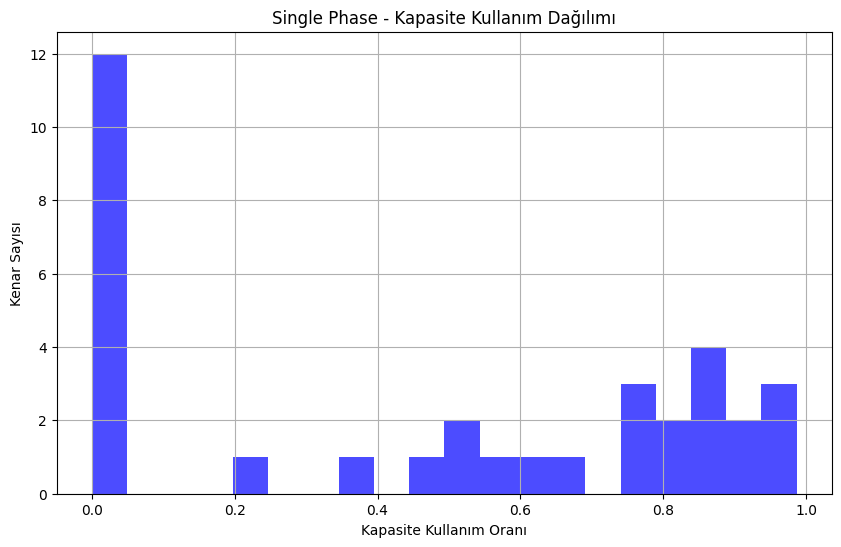

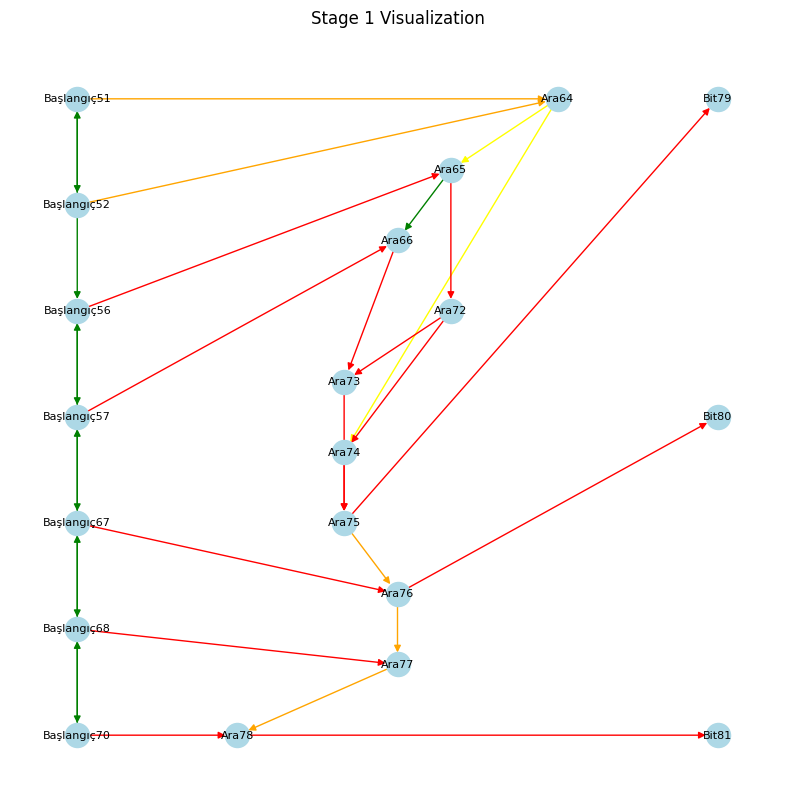

In [7]:
run_single_phase_optimization()
